In [1]:
import control as ct, numpy as np, matplotlib.pyplot as plt

# Funções de transferência do controlador PID discreto:
# $$G_c(z) = K_p + \frac{K_i}{1-z^{-1}} + K_d\cdot(1-z^-1)$$

# $$G_c(z) = K_C \cdot \frac{(z-z_{c1})\cdot(z-z_{c2})}{z\cdot(z-1)}$$

In [2]:
def create_servo(k, tau):
    return k*ct.tf(1, [1, 0])*ct.tf(1, [tau, 1])

In [3]:
def plot_response(sys, t, u, grid_major = 1, grid_minor = 0.2, display = True):
    response = ct.forced_response(ct.feedback(sys), t, u)
    if display:
        plt.grid()
        plt.plot(response.time, response.outputs)
        plt.show()
    return response

In [4]:
k = 735
tau = 0.055
T = 1e-3

servo = create_servo(k, tau)
servo

TransferFunction(array([735.]), array([0.055, 1.   , 0.   ]))

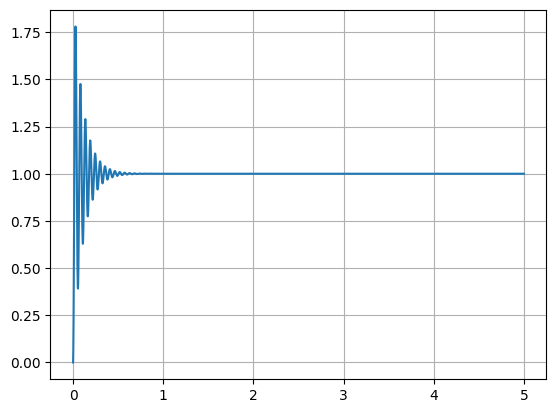

In [5]:
time = np.arange(0, 5, T)
step = np.ones(len(time))
resp = plot_response(servo, time, step)

In [6]:
def project_pid(sys, csi, ts, T, theta=-3):
    omega_n = 4/(ts*csi)
    omega_d = omega_n * np.sqrt(1-csi**2)
    dom_s = -csi*omega_n + 1j*omega_d
    dom_z = np.e**(T*dom_s)
    sigma = dom_z.real
    omega = dom_z.imag
    gz = ct.c2d(sys, T)
    zc1 = np.sort(gz.poles())[-2]
    tan = np.tan(np.deg2rad(theta))
    zc2 = (tan*(np.abs(dom_z)**2-sigma)+omega)/(omega+tan*(sigma-1))
    gc_num = np.convolve([1, -zc1], [1, -zc2])
    gc_den = np.convolve([1, 0], [1, -1])
    gc = ct.tf(gc_num, gc_den, T)
    series = gz*gc
    kc = 1/np.abs(series(dom_z))
    return gz, kc*gc

In [7]:
gz, gc = project_pid(servo, csi=0.8, ts=0.03, T=T)

c:\Users\nikgr\AppData\Local\Programs\Python\Python311\Lib\site-packages\control\statesp.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


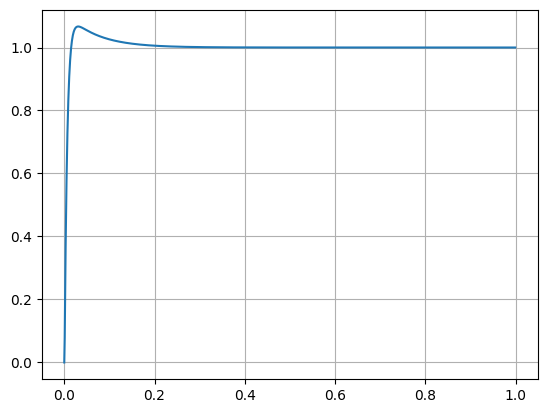

In [8]:
time = np.arange(0, 1, T)
step = np.ones(len(time))
resp = plot_response(gc*gz, time, step)

In [9]:
resp_nc = plot_response(servo, time, step, display=False)
resp_c = plot_response(gc*gz, time, step, display=False)

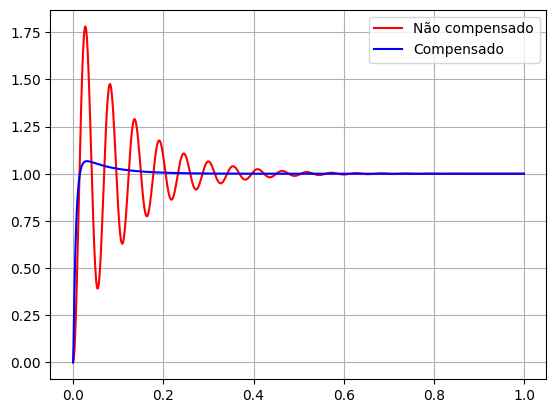

In [10]:
plt.grid()
plt.plot(resp_nc.time, resp_nc.outputs, c='r', label="Não compensado")
plt.plot(resp_c.time, resp_c.outputs, c='b', label="Compensado")
plt.legend()
plt.show()